### Задание

1. Обучить модель на понравившихся данных
2. Создать rest api сервис, к которому можно будет обращаться для получения прогнозов

### Примерные темы

1. Определение токсичности комментария
2. Определение стоимости жилья от разных факторов: площадь жилья, удаленность от центра, etc (здесь же куча идей прогнозирования стоимости чего-либо по его описанию)
3. Темы новости по ее тексту
4. Классификатор рукописных цифр
5. Классификатор картинок (например, определение города и страны по снимку улицы)
6. Определение вероятности наличия сердечно-сосудистых заболеваний по данным первичного осмотра (или что-то подобное)
7. Многое другое (придумайте сами)
8. Прогнозирование рейтинга вопроса на stackoverflow - https://www.kaggle.com/imoore/60k-stack-overflow-questions-with-quality-rate
9. https://www.kaggle.com/russellyates88/suicide-rates-overview-1985-to-2016
10. Тематическое моделирование статей на arxiv - https://www.kaggle.com/Cornell-University/arxiv

### Откуда брать данные

1. kaggle (https://www.kaggle.com/datasets)
2. спарсить самостоятельно, но в этом случае вам может понадобиться разметка (если у вас обучение с учителем)

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
import pickle
import time
import dill
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

df_train = pd.read_csv("../Final project/train.csv")
df_test = pd.read_csv("../Final project/test.csv")
submission = pd.read_csv("../Final project/sample_submission.csv")




In [44]:
df_target = df_train['Transported']
df_target

0       False
1        True
2       False
3       False
4        True
        ...  
8688    False
8689    False
8690     True
8691    False
8692     True
Name: Transported, Length: 8693, dtype: bool

In [45]:
df_train.drop(columns=["PassengerId"],inplace=True)
df_train.drop(columns=["Name"],inplace=True)
df_test.drop(columns=["Name"],inplace=True)
df_train.drop(columns=["Cabin"],inplace=True)
df_test.drop(columns=["Cabin"],inplace=True)

In [46]:
df_train.head(10)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True
5,Earth,False,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,True
6,Earth,False,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,True
7,Earth,True,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,True
8,Earth,False,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,True
9,Europa,True,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,True


In [47]:
numerical_features = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
categorical_features = ["HomePlanet", "CryoSleep", "Destination", "VIP"]
categorical_features_test = ["PassengerId","HomePlanet", "CryoSleep", "Destination", "VIP"]

In [48]:
cat_df_train = df_train[categorical_features]
num_df_train = df_train[numerical_features]
imp_cat = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp_num = SimpleImputer(missing_values=np.nan, strategy='median')
cat_df_train = pd.DataFrame(imp_cat.fit_transform(cat_df_train),
                   columns=cat_df_train.columns,
                   index=cat_df_train.index)
cat_df_test = df_test[categorical_features_test]
num_df_test = df_test[numerical_features]
cat_df_test = pd.DataFrame(imp_cat.fit_transform(cat_df_test),
                   columns=cat_df_test.columns,
                   index=cat_df_test.index)

In [49]:
num_df_train = pd.DataFrame(imp_num.fit_transform(num_df_train),
                   columns=num_df_train.columns,
                   index=num_df_train.index)
num_df_test = pd.DataFrame(imp_num.fit_transform(num_df_test),
                   columns=num_df_test.columns,
                   index=num_df_test.index)
#num_df_train = df_train[numerical_features].fillna(df_train[numerical_features].median())
#num_df_test = df_test[numerical_features].fillna(df_test[numerical_features].median())
num_df_train

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,39.0,0.0,0.0,0.0,0.0,0.0
1,24.0,109.0,9.0,25.0,549.0,44.0
2,58.0,43.0,3576.0,0.0,6715.0,49.0
3,33.0,0.0,1283.0,371.0,3329.0,193.0
4,16.0,303.0,70.0,151.0,565.0,2.0
...,...,...,...,...,...,...
8688,41.0,0.0,6819.0,0.0,1643.0,74.0
8689,18.0,0.0,0.0,0.0,0.0,0.0
8690,26.0,0.0,0.0,1872.0,1.0,0.0
8691,32.0,0.0,1049.0,0.0,353.0,3235.0


In [50]:
df_train = cat_df_train.join(num_df_train)
df_test = cat_df_test.join(num_df_test)
df_train = pd.get_dummies(df_train, columns=["HomePlanet", "CryoSleep", "Destination", "VIP"])
df_test = pd.get_dummies(df_test, columns=["HomePlanet", "CryoSleep", "Destination", "VIP"])

In [51]:
test_id = df_test['PassengerId']
df_test.drop(columns=["PassengerId"],inplace=True)

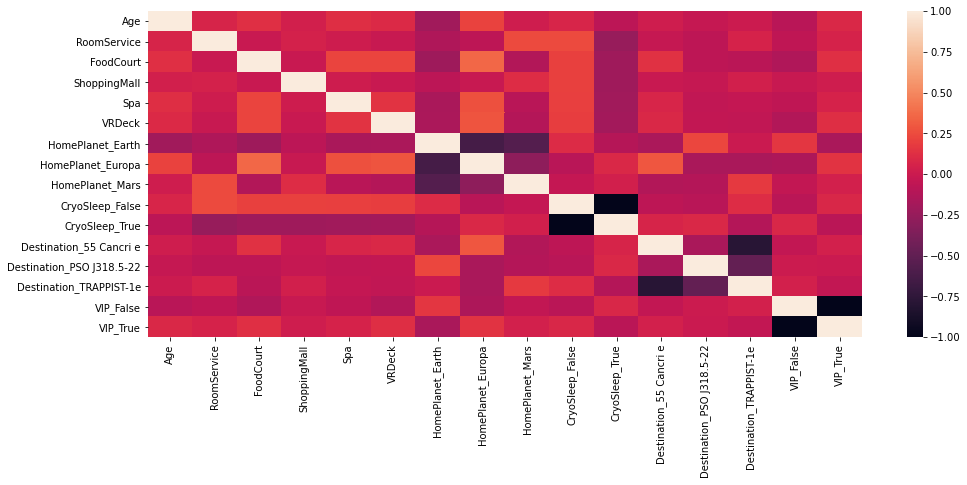

In [52]:
plt.figure(figsize=(16, 6)) 
sns.heatmap(df_train.corr());

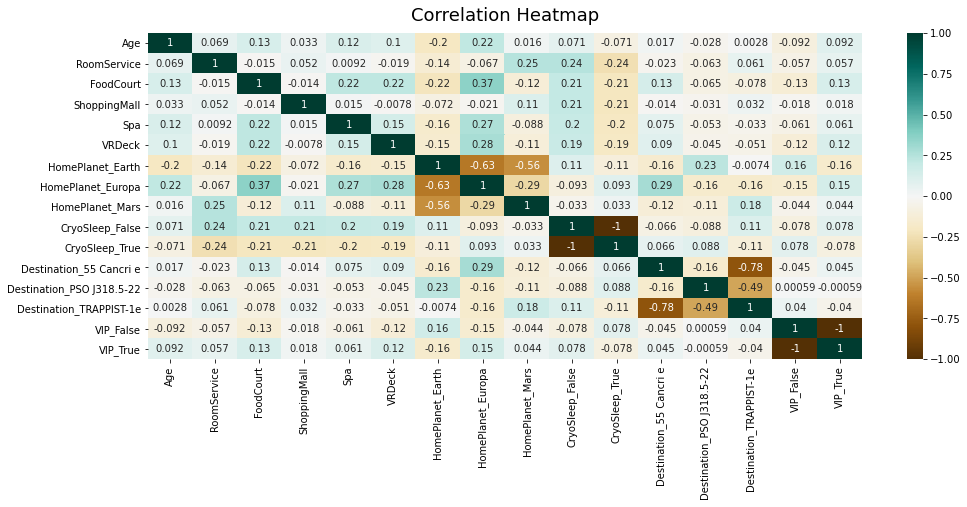

In [53]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df_train.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12); 

# Сохраните карту как png файл 
# Параметр dpi устанавливает разрешение сохраняемого изображения в точках на дюйм 
# bbox_inches, когда установлен в значение 'tight', не позволяет обрезать лейблы

plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')

(array([245., 150., 104.,  92.,  88.,  86., 182., 293., 305., 613., 588.,
        583., 567., 706., 497., 385., 377., 319., 355., 299., 257., 247.,
        204., 185., 155., 133., 113., 135.,  94.,  82.,  66.,  52.,  52.,
         20.,  18.,  16.,  11.,   9.,   4.,   6.]),
 array([ 0.   ,  1.975,  3.95 ,  5.925,  7.9  ,  9.875, 11.85 , 13.825,
        15.8  , 17.775, 19.75 , 21.725, 23.7  , 25.675, 27.65 , 29.625,
        31.6  , 33.575, 35.55 , 37.525, 39.5  , 41.475, 43.45 , 45.425,
        47.4  , 49.375, 51.35 , 53.325, 55.3  , 57.275, 59.25 , 61.225,
        63.2  , 65.175, 67.15 , 69.125, 71.1  , 73.075, 75.05 , 77.025,
        79.   ]),
 <BarContainer object of 40 artists>)

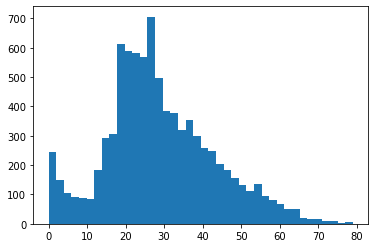

In [54]:
plt.hist(df_train['Age'], bins=40)

In [55]:
df_train.isnull().sum()

Age                          0
RoomService                  0
FoodCourt                    0
ShoppingMall                 0
Spa                          0
VRDeck                       0
HomePlanet_Earth             0
HomePlanet_Europa            0
HomePlanet_Mars              0
CryoSleep_False              0
CryoSleep_True               0
Destination_55 Cancri e      0
Destination_PSO J318.5-22    0
Destination_TRAPPIST-1e      0
VIP_False                    0
VIP_True                     0
dtype: int64

In [56]:
df_train = df_train[['Age','FoodCourt' ,'Spa']]

In [57]:
X_train, X_test, y_train, y_test = train_test_split(df_train, df_target, 
                                            test_size=0.2, random_state=42)

In [58]:
y_test 

304      True
2697    False
8424    False
1672     True
8458     True
        ...  
7175    False
3187     True
1302    False
5934     True
6093    False
Name: Transported, Length: 1739, dtype: bool

In [59]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(max_iter=10000, random_state=0).fit(X_train, y_train)
log_reg.coef_


array([[-0.00569922,  0.00031595, -0.00202903]])

In [60]:
log_reg.predict_proba(X_test)[:,1]

array([0.59144501, 0.63577619, 0.53503787, ..., 0.43772877, 0.53361978,
       0.03269585])

In [61]:
from joblib import dump, load
dump(log_reg, 'model.joblib')

['model.joblib']

In [62]:
start_time = time.time()

rfc = RandomForestClassifier(n_estimators=525,max_features='log2',criterion='entropy',random_state = 0)
gbdt = GradientBoostingClassifier(n_estimators=1178,max_depth=12,subsample=0.75,learning_rate=0.0079,random_state=79)
xgb = XGBClassifier(n_estimators=2470,max_depth=8,eval_metric='logloss',learning_rate=0.0061)
lgbm = LGBMClassifier(n_estimators=2284,learning_rate=0.0373,num_leaves=128,boosting_type='dart',max_depth=22)
cat = CatBoostClassifier(bootstrap_type='Bernoulli',max_depth = 8,learning_rate=0.0763,n_estimators=1461,silent = True,random_state=37)

vc = VotingClassifier([('RandomForestClassifier',rfc),('Gradient Boost',gbdt),
                       ('XG Boost', xgb),('LightGBM',lgbm),('CatboostClassifier',cat)]
                     ,n_jobs = 4,verbose = 2,voting = 'hard')

vc.fit(df_train, df_target)

end_time = time.time()
print(vc.score(X_test,y_test))

0.8148361127084531


In [63]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.0061, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=8, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=2470, n_jobs=0, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1, ...)

In [64]:
y_score = xgb.predict_proba(X_test)[:, 1]
y_score

array([0.49765122, 0.643331  , 0.72595954, ..., 0.2601862 , 0.6554002 ,
       0.05989274], dtype=float32)

In [65]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
b = 1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.990123, F-Score=nan, Precision=0.000, Recall=0.000


<ipython-input-65-f0697a1caff7>:4: RuntimeWarning: invalid value encountered in true_divide
  fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)


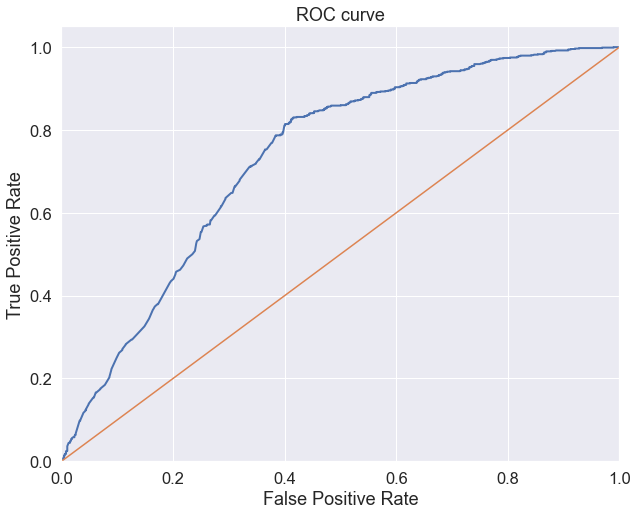

In [66]:
import seaborn as sns
import itertools
import matplotlib.pyplot as plt

%matplotlib inline
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

In [67]:
#with open("../Final project/model.dill", "wb") as f:
#    dill.dump(vc, f)

In [68]:
#pickle.dump(xgb, open('../Final project/model.pkl','wb'))

In [69]:
#submission = vc.predict(df_test)
#submission

In [70]:
#submission = pd.DataFrame(submission)
#submission.rename(columns = {0 : 'Transported'}, inplace = True)
#submission

In [71]:
#final = pd.DataFrame(test_id)
#final

In [72]:
#f = final.join(submission)
#f

In [73]:
#f.to_csv('../Final project/final.csv',index=False)